In [1]:
import numpy as np

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
from config import tracker, bokeh_viz
from skimage.draw import polygon

In [5]:
import imageio

In [6]:
import pickle

In [7]:
from pathlib import Path

In [245]:
def draw_bbox(img, boxes):
    img_l = img.copy()
    c0 = [(255,0,0), (255,255,0), (255,255,0), (255,255,0)]
    c1 = [(255,0,0), (0,255,255), (0,255,255), (0,255,255)]
    for rec in boxes:
        box = rec['box']
        c = c0 if rec['hand'] == 0 else c1
        
        for i in range(4):
            beg = tuple(box[i])
            end = tuple(box[(i+1) % 4])
            cv2.line(img_l, beg, end, c[i], 2)
            
    return img_l

In [239]:
reader = imageio.get_reader(vids[0])

In [240]:
frames = [x for i,x in zip(range(200), reader)]

In [241]:
reader.close()

In [246]:
new_boxes[102]

[151, [{'box': array([[537, 739],
          [229, 803],
          [164, 494],
          [473, 430]]),
   'center': array([351.21236086, 896.83630168]),
   'size': 315.16687774658203,
   'hand': 0},
  {'box': array([[616, 233],
          [886, 270],
          [848, 540],
          [579, 502]]),
   'center': array([732.83623934, 666.80621624]),
   'size': 272.16746520996094,
   'hand': 1}]]

In [247]:
res = draw_bbox(frames[151], new_boxes[102][1])

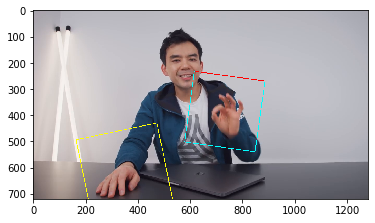

In [248]:
plt.imshow(res)

In [259]:
root_dir = Path("~/data/unlabelled/").expanduser()

In [260]:
vids = sorted((root_dir / "0source").glob("*.mp4"))

In [261]:
pth = vids[0]

In [264]:
cap = imageio.get_reader(pth)
writer = imageio.get_writer(root_dir / "1boxed" / pth.name, fps=24)

In [268]:
j = 0
for i, img in tqdm(enumerate(cap), total=cap.count_frames()):
    if new_boxes[j][0] == i:
        bx = new_boxes[j][1]
        drawn = draw_bbox(img, bx)
        writer.append_data(drawn)
        j+=1
        
cap.close()
writer.close()

In [262]:
pth.name.replace("mp4","pkl")

'dave_2d.pkl'

In [27]:
pth.with_suffix(".pkl")

PosixPath('/home/wolterlw/data/unlabelled/0source/hand_work.pkl')

In [33]:
cap.count_frames()

17225

In [36]:
for vid in vids:
    cap = imageio.get_reader(vid)
    writer = imageio.get_writer(root_dir / "1boxed" / vid.name, fps=30)
    boxes = []
    n_frames = cap.count_frames()
    
    for i, img in tqdm(enumerate(cap), total=n_frames):
        bx = tracker(img)
        if 0<len(bx)<3:
            boxes.append([i, bx])
        drawn = draw_bbox(img, bx)
        writer.append_data(drawn)
        
    writer.close()
    cap.close()
    
    with open(vid.with_suffix(".pkl"),"wb") as f:
        pickle.dump(boxes, f)

In [11]:
with open("/home/wolterlw/data/unlabelled/0source/dave_2d.pkl",'rb') as f:
    boxes = pickle.load(f)

In [15]:
new_boxes = []

In [16]:
for i, bx in enumerate(boxes):
    if 0<len(bx) <= 2:
        new_boxes.append([i, bx])

In [17]:
centers = [(i, [x['center'] for x in b]) for i,b in new_boxes]

In [18]:
segments = []

In [103]:
crd0 = new_boxes[1]
crd1 = new_boxes[2]
crd2 = new_boxes[3]

In [104]:
cnt0 = np.c_[[x['center'] for x in crd0[1]]]

In [105]:
cnt1 = np.c_[[x['center'] for x in crd1[1]]]

In [250]:
class HandTracker():
    def __init__(self,):
        self.reset()
    
    def reset(self):
        self.h = np.zeros([0,2])
    
    def track(self, boxes):
        centers = np.c_[[x['center'] for x in boxes[1]]]
        assert len(centers) > 0
        idx = list(range(len(centers)))
        for i, h in enumerate(self.h):
            dists = np.linalg.norm(h - centers[idx],axis=1)
            
            k = np.argmin(dists)
            self.h[i] = centers[idx[k]]
            new_hand = idx.pop(k)
            boxes[1][new_hand]['hand'] = i
            if len(idx) == 0:
                break
        if idx:
            print("new hands")
            offs = len(self.h)
            self.h = np.concatenate([self.h, centers[idx]])
            for i in idx:
                boxes[1][i]['hand'] = offs
                offs+=1

In [251]:
tracker = HandTracker()

In [252]:
_ = [tracker.track(nb) for nb in tqdm(new_boxes)]

new hands



In [257]:
tracker.h

array([[561.44784212, 787.77387917],
       [611.53376579, 786.29943848]])

In [255]:
tracker.track(new_boxes[5])

In [206]:
new_boxes[-5]

[8165, [{'box': array([[524, 309],
          [472, 469],
          [311, 417],
          [363, 256]]),
   'center': array([418.09595734, 643.18091512]),
   'size': 168.92075729370117,
   'hand': 0}]]

In [185]:
tracker.track(new_boxes[0])

new hands


In [186]:
new_boxes[0][1]

[{'box': array([[799, 469],
         [727, 616],
         [579, 543],
         [652, 396]]),
  'center': array([689.69458818, 786.63605213]),
  'size': 164.6309051513672,
  'hand': 0},
 {'box': array([[812, 419],
         [836, 555],
         [700, 578],
         [676, 442]]),
  'center': array([756.5241766 , 778.91645551]),
  'size': 138.00762176513672,
  'hand': 1}]

In [170]:
tracker.h

array([[689.69458818, 786.63605213],
       [756.5241766 , 778.91645551]])

In [171]:
tracker.track(new_boxes[1])

In [172]:
new_boxes[1]

[15, [{'box': array([[722, 437],
          [733, 559],
          [610, 570],
          [600, 448]]),
   'center': array([666.74064338, 783.82334113]),
   'size': 122.56742477416992,
   'hand': 0},
  {'box': array([[776, 434],
          [857, 510],
          [781, 590],
          [700, 514]]),
   'center': array([779.08322483, 792.60567188]),
   'size': 110.54942321777344,
   'hand': 1}]]

In [146]:
tracker.h

array([[609.91999149, 786.19416058],
       [783.25098425, 791.6047585 ]])

In [127]:
tracker.h

array([[608.28978539, 784.90933001],
       [783.25098425, 791.6047585 ]])

In [128]:
cnt0

array([[666.74064338, 783.82334113],
       [779.08322483, 792.60567188]])

In [129]:
cnt1

array([[608.28978539, 784.90933001],
       [783.25098425, 791.6047585 ]])

In [ ]:
i_prev = 0

for i,cnt in centers:
    (i - i_prev) > 3:
        segments.append([])
        
    segments[-1]

In [53]:
cnt1 = np.c_[centers[4][1]]

In [54]:
cnt2 = np.c_[centers[5][1]]

In [70]:
np.linalg.norm(cnt1 - cnt2, axis=1).sum()

2.00585814244206

In [93]:
np.linalg.norm(cnt1 - np.c_[centers[3][1]], axis=1)

array([50.20723337,  1.57311078])

In [75]:
cnt3 = np.c_[centers[6][1]]

In [74]:
direct = cnt1 - cnt2

In [78]:
direct2 = cnt2 - cnt3

In [79]:
direct2

array([[ 1.30229235, -0.27755737],
       [-0.54157495, -0.63385963]])

In [80]:
direct

array([[-1.72484517, -0.56580484],
       [-0.04272223, -0.18573225]])

In [86]:
(direct * direct2).sum(axis=1)

array([-2.08920936,  0.14086546])

In [87]:
(direct * direct2[::-1]).sum(axis=1) 

array([ 1.29277379, -0.00408547])

In [84]:
direct[0] @ direct2[0]

-2.08920936103425

In [71]:
np.linalg.norm(cnt1 - cnt2[::-1], axis=1).sum()

101.88946769238271

In [51]:
np.c_[cnt1]

array([[559.72299695, 787.20807433],
       [611.49104357, 786.11370623]])

In [52]:
np.c_[cnt2]

array([[561.44784212, 787.77387917],
       [611.53376579, 786.29943848]])

In [39]:
centers[4:9]

[(18,
  [array([559.72299695, 787.20807433]), array([611.49104357, 786.11370623])]),
 (19,
  [array([561.44784212, 787.77387917]), array([611.53376579, 786.29943848])]),
 (21,
  [array([560.14554977, 788.05143654]), array([612.07534075, 786.93329811])]),
 (22,
  [array([559.65679407, 788.25950265]), array([612.65985012, 787.17174113])]),
 (23,
  [array([557.28730679, 788.11640918]), array([612.34731436, 787.02441156])])]

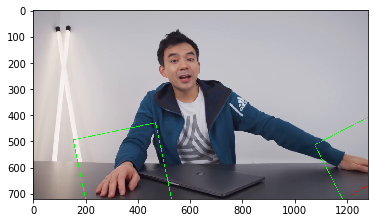

In [32]:
plt.imshow(
    draw_bbox(frames[i+10][0], boxes[310])
)

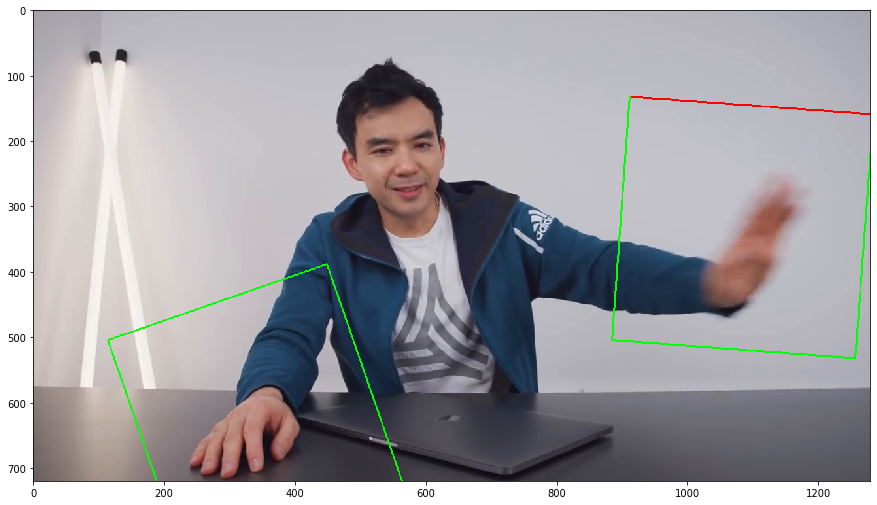

In [28]:
plt.figure(figsize=(15,15))
img = frames[i][0].copy()


for rec in boxes[300]:
    box = rec['box']
    for j in range(4):
        cv2.line(img, tuple(box[j]), tuple(box[(j+1) % 4]), c[j], 2)

plt.imshow(img)



In [ ]:
bokeh_viz(frames)

In [ ]:
img, norm, pad = tracker.preprocess_img(frames[0])

In [ ]:
hands = tracker.detect_hand(norm, 1280)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.xlim(0,img.shape[1])
plt.ylim(img.shape[0],0)

boxes = []

ver_vecs = []
hor_vecs = []

for hand in hands:
    # hand = hands[0]
    lm = hand['landmarks'][3]
    hw = hand['height_width'][0]

    ver_vec = lm[[0,2]]
    hor_vec = lm[[1,4]]
    
    

    bbox = get_bbox(hor_vec, size=max(hw)*3)
    
    boxes.append(bbox)
    ver_vecs.append(ver_vec)
    hor_vecs.append(hor_vec)

    plt.scatter(lm[:,0], lm[:,1], c='gray')
    plt.plot(ver_vec[:,0], ver_vec[:,1], c='m')
    plt.plot(hor_vec[:,0], hor_vec[:,1], c='c')

    for j in range(4):
        plt.plot(bbox[[j,(j+1) % 4], 0], bbox[[j,(j+1) % 4], 1], c='#00ff00')
        plt.text(*bbox[j]+np.r_[10,10], str(j), color='#ff00ff')

In [ ]:
pts = hor_vecs[0].astype('int')

In [ ]:
box = bbox_by_hvec(hor_vecs[1].astype('int'), size=250)

In [ ]:
plt.figure(figsize=(15,15))

plt.imshow(img)
for j in range(4):
    plt.plot(box[[j,(j+1) % 4], 0], box[[j,(j+1) % 4], 1], c='#00ff00')
    plt.text(*box[j]+np.r_[10,10], str(j), color='#ff00ff')

In [ ]:
hor_vecs[0]

In [ ]:
target = np.r_[[
    [256,256],
    [0,256],
    [0,0],
]].astype('float32')

In [ ]:
R = cv2.getAffineTransform(boxes[0][:3].astype('float32'), target)

In [ ]:
boxes0 = boxes

In [ ]:
def get_mblur(prev, cur):
    flow = cv2.calcOpticalFlowFarneback(prev[:,:,0], cur[:,:,0], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow


def get_new_bb(frame1, frame2, bboxes):
    flow = get_mblur(frame1, frame2)
    new_boxes = []
    
    for box in bboxes:
        y,x = polygon(box[:,0], box[:,1])
        changes = np.abs(flow[y,x].round() > 3).sum()
        if changes > 1000:
            dydx = flow[y,x].sum(axis=0) / changes
            norm = np.linalg.norm(dydx)
            if norm > 20:
                dydx = dydx / norm * 20
        else:
            dydx = np.r_[0,0]
        new_boxes.append(box + dydx)
    return new_boxes

In [ ]:
boxes = boxes0

In [ ]:
res = []



for i in tqdm(range(0,len(frames))):
    f0 = tracker.preprocess_img(frames[i])[0]
    f1 = tracker.preprocess_img(frames[i+1])[0]

    new_boxes = get_new_bb(f0, f1, boxes)

    for box in new_boxes:
        box = box.astype('int')
        for j in range(4):
            cv2.line(f1, tuple(box[j]), tuple(box[(j+1) % 4]), color=(0,255,0), thickness=5)
    boxes = new_boxes
    res.append(f1)

In [ ]:
bokeh_viz(res)

In [ ]:
img = res[53][300:1000, 300:1000, 0]

In [ ]:
plt.figure(figsize=(15,15))
sob1 = cv2.Sobel(img, cv2.CV_64F, 0, 1)
sob2 = cv2.Sobel(img, cv2.CV_64F, 1, 0)
sob = np.abs(sob1 + sob2)
plt.imshow(sob)

In [ ]:
plt.imshow(flow[:,:,1])

In [ ]:
plt.imshow(frames[1])

In [ ]:
def draw_hand(img, coords):
    img_l = img.copy()
    for b,e in [(0,1), (1,2), (2,3), (3,4),
            (5,6), (6,7), (7,8),
            (9,10),(10,11), (11,12),
            (13,14), (14,15), (15,16),
            (17,18), (18,19), (19,20),
            (0,5), (5,9), (9,13), (13,17), (17,0)
           ]:
        beg = tuple(coords[b])
        end = tuple(coords[e])
        cv2.line(img_l, beg, end, (0,255,0), 2)
    return img_l

In [ ]:
res = []
for frm, crd in zip(frames, coords):
    if not crd is None:
        frm = draw_hand(frm, crd.astype('int'))
    res.append(
        frm
    )

In [ ]:
bokeh_viz(res)

In [ ]:
akaze = cv2.AKAZE_create()

In [ ]:
res0 = akaze.detectAndCompute(frames[127][:,:,0], None)
res1 = akaze.detectAndCompute(frames[128][:,:,0], None)

In [ ]:
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

In [ ]:
nn_matches = matcher.knnMatch(res0[1], res1[1], 2)

In [ ]:
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(res0[0][m.queryIdx])
        matched2.append(res1[0][m.trainIdx])

In [ ]:
pairs = []
for m1, m2 in zip(matched1, matched2):
    pair = np.r_[[m1.pt, m2.pt]]
    pair[1] += np.r_[frames[0].shape[1], 0]
    pairs.append(pair)

In [ ]:
np.c_[pairs].shape

In [ ]:
i = 24

In [ ]:
pair = np.r_[[matched1[i].pt, matched2[i].pt]]

In [ ]:
pair[1] = pair[1] + np.r_[frames[0].shape[1], 0]

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(
    np.concatenate([frames[127], frames[128]],axis=1)
)
for pair in pairs:
    plt.plot(pair[:,0], pair[:,1], alpha=0.3)

In [ ]:
f,ax = plt.subplots(1,2, figsize=(15,15))

ax[0].imshow(frames[127])
ax[1].imshow(frames[128])